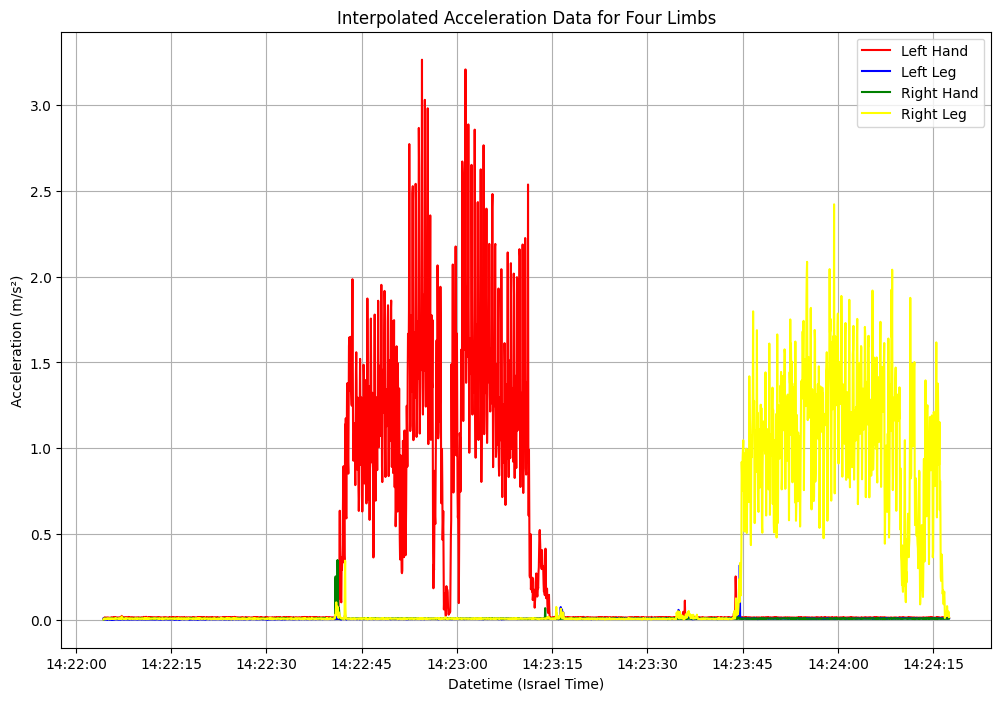

In [ ]:
import h5py
import numpy as np
from datetime import datetime, timedelta
import pytz
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Load the HDF5 file
file_path = '../data/Mobile.2024.12.04.5000.04.015.sensor.h5'
file_path_meta = '../data/Mobile.2024.12.04.5000.04.015.h5'

# Define the colors for each limb
colors = {
    'Left Hand': 'red',
    'Right Hand': 'green',
    'Left Leg': 'blue',
    'Right Leg': 'yellow',
}

# Step 1: Load and extract data for all four limbs
limb_data = {}
with h5py.File(file_path, 'r') as h5_file:
    limb_data['Left Hand'] = h5_file['measurement/MetaWear Sensors Control/left_hand_data'][:]
    limb_data['Left Leg'] = h5_file['measurement/MetaWear Sensors Control/left_leg_data'][:]
    limb_data['Right Hand'] = h5_file['measurement/MetaWear Sensors Control/right_hand_data'][:]
    limb_data['Right Leg'] = h5_file['measurement/MetaWear Sensors Control/right_leg_data'][:]

# Step 2: Convert timestamps to actual date and time
epoch_start = datetime(1970, 1, 1)  # Unix epoch
formatted_data = {}
for limb, time_accel in limb_data.items():
    times = [epoch_start + timedelta(seconds=t) for t in time_accel[:, 0]]
    formatted_data[limb] = {
        "datetime": np.array(times),
        "acceleration": time_accel[:, 1]
    }

# Step 3: Adjust timestamps to Israel timezone
israel_tz = pytz.timezone("Asia/Jerusalem")
formatted_data_israel = {}
for limb, data in formatted_data.items():
    times_israel = [t.replace(tzinfo=pytz.utc).astimezone(israel_tz) for t in data["datetime"]]
    formatted_data_israel[limb] = {
        "datetime": np.array(times_israel),
        "acceleration": data["acceleration"]
    }

# Step 4: Create a unified timeline with 50 ms (0.05 seconds) period
start_time = max(data["datetime"][0] for data in formatted_data_israel.values())
end_time = min(data["datetime"][-1] for data in formatted_data_israel.values())
unified_timeline = np.arange(start_time.timestamp(), end_time.timestamp(), 0.05)

# Step 5: Interpolate the data for all limbs onto the unified timeline
interpolated_data = {}
for limb, data in formatted_data_israel.items():
    # Convert datetime to timestamps for interpolation
    timestamps = np.array([dt.timestamp() for dt in data["datetime"]])
    acceleration = data["acceleration"]
    
    # Create interpolation function
    interp_func = interp1d(timestamps, acceleration, kind='linear', fill_value="extrapolate")
    
    # Apply interpolation on the unified timeline
    interpolated_acceleration = interp_func(unified_timeline)
    interpolated_data[limb] = interpolated_acceleration

# Step 6: Plot the interpolated data
plt.figure(figsize=(12, 8))
unified_datetime = [datetime.fromtimestamp(ts, tz=israel_tz) for ts in unified_timeline]
for limb, interpolated_accel in interpolated_data.items():
    plt.plot(unified_datetime, interpolated_accel, label=limb, color=colors[limb])

plt.title("Interpolated Acceleration Data for Four Limbs")
plt.xlabel("Datetime (Israel Time)")
plt.ylabel("Acceleration (m/s²)")
plt.legend()
plt.grid()
plt.show()


In [149]:
# create a new dataframe from interpolated_data and unified_datetime
interpolated_df = pd.DataFrame(interpolated_data, index=unified_datetime)
interpolated_df.index.name = 'datetime'
interpolated_df

,Left Hand,Left Leg,Right Hand,Right Leg
datetime,,,,
2024-12-04 14:22:04.343155+02:00,0.005520,0.007837,0.001567,0.002789
2024-12-04 14:22:04.393155+02:00,0.010221,0.002210,0.004841,0.006799
2024-12-04 14:22:04.443155+02:00,0.011804,0.001175,0.007239,0.004894
2024-12-04 14:22:04.493155+02:00,0.012499,0.001513,0.006635,0.006619
2024-12-04 14:22:04.543155+02:00,0.011792,0.002296,0.005202,0.005047
...,...,...,...,...
2024-12-04 14:24:17.293028+02:00,0.012409,0.007232,0.006860,0.039197
2024-12-04 14:24:17.343028+02:00,0.011190,0.006701,0.006189,0.032997
2024-12-04 14:24:17.393028+02:00,0.012184,0.006381,0.007433,0.049141


In [150]:
import h5py
import pandas as pd
from datetime import datetime
import pytz

# Load the HDF5 file

# Step 1: Extract the events table from the HDF5 file
events_data = None
with h5py.File(file_path_meta, 'r') as h5_file:
    events_data = h5_file['measurement/Task Management/events'][:]

# Step 2: Convert to a pandas DataFrame for better readability
events_table = pd.DataFrame(events_data, columns=["Event Name", "Event Type", "Timestamp"])

# Step 3: Decode byte strings to plain strings using map
events_table["Event Name"] = events_table["Event Name"].map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
events_table["Event Type"] = events_table["Event Type"].map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
events_table["Timestamp"] = events_table["Timestamp"].map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Step 4: Group by Event Name and organize into a new table with Start Time and End Time
events_grouped = events_table.groupby("Event Name")
manipulated_table = pd.DataFrame(columns=["Event Name", "Start Time", "End Time"])

for event_name, group in events_grouped:
    start_time = group[group["Event Type"] == "Start"]["Timestamp"].values
    end_time = group[group["Event Type"] == "End"]["Timestamp"].values
    manipulated_table = pd.concat([
        manipulated_table,
        pd.DataFrame({
            "Event Name": [event_name],
            "Start Time": start_time[0] if len(start_time) > 0 else None,
            "End Time": end_time[0] if len(end_time) > 0 else None
        })
    ], ignore_index=True)

# Step 5: Filter out "Task" and "Fixation" events
filtered_table = manipulated_table[
    ~manipulated_table["Event Name"].isin(["Task", "Fixation"])
]

# Step 6: Sort the table by Start Time
filtered_table_sorted = filtered_table.sort_values(by="Start Time").reset_index(drop=True)

# Step 7: Display the final table
print(filtered_table_sorted)


   Event Name                  Start Time                    End Time
0   Base Line  2024-12-04T14:22:08.602140  2024-12-04T14:22:38.635108
1     Connect  2024-12-04T14:22:40.853723  2024-12-04T14:23:10.915820
2  Disconnect  2024-12-04T14:23:13.141130  2024-12-04T14:23:43.189849
3   Reconnect  2024-12-04T14:23:45.409893  2024-12-04T14:24:15.474400


In [151]:
# Convert Start Time and End Time to datetime
filtered_table_sorted['Start Time'] = pd.to_datetime(filtered_table_sorted['Start Time'])
filtered_table_sorted['End Time'] = pd.to_datetime(filtered_table_sorted['End Time'])

# Localize Start Time and End Time to the same timezone as interpolated_df index
israel_tz = pytz.timezone("Asia/Jerusalem")
filtered_table_sorted['Start Time'] = filtered_table_sorted['Start Time'].dt.tz_localize(israel_tz, ambiguous='NaT', nonexistent='NaT')
filtered_table_sorted['End Time'] = filtered_table_sorted['End Time'].dt.tz_localize(israel_tz, ambiguous='NaT', nonexistent='NaT')

# Create a dictionary to store the segmented dataframes
segmented_data = {}

# Iterate over each event and segment the interpolated_df
for index, row in filtered_table_sorted.iterrows():
    event_name = row['Event Name']
    start_time = row['Start Time']
    end_time = row['End Time']
    
    # Filter the interpolated_df based on the start and end time
    segment_df = interpolated_df[(interpolated_df.index >= start_time) & (interpolated_df.index <= end_time)]
    
    # Store the segmented dataframe in the dictionary
    segmented_data[event_name] = segment_df

# Print the segmented dataframes
for event_name, segment_df in segmented_data.items():
    print(f"Segment for {event_name}:")
    print(segment_df)
    print("\n")

Segment for Base Line:
                                  Left Hand  Left Leg  Right Hand  Right Leg
datetime                                                                    
2024-12-04 14:22:08.643151+02:00   0.011887  0.004735    0.007434   0.006065
2024-12-04 14:22:08.693151+02:00   0.012353  0.002224    0.007544   0.005993
2024-12-04 14:22:08.743151+02:00   0.014022  0.002628    0.008029   0.007337
2024-12-04 14:22:08.793151+02:00   0.015651  0.002091    0.007634   0.007312
2024-12-04 14:22:08.843151+02:00   0.014381  0.001599    0.007441   0.006062
...                                     ...       ...         ...        ...
2024-12-04 14:22:38.393122+02:00   0.012982  0.004743    0.007406   0.007117
2024-12-04 14:22:38.443122+02:00   0.014494  0.004265    0.007818   0.007411
2024-12-04 14:22:38.493122+02:00   0.013480  0.004508    0.008505   0.008132
2024-12-04 14:22:38.543122+02:00   0.013687  0.005218    0.004169   0.006273
2024-12-04 14:22:38.593122+02:00   0.014359  0.006021

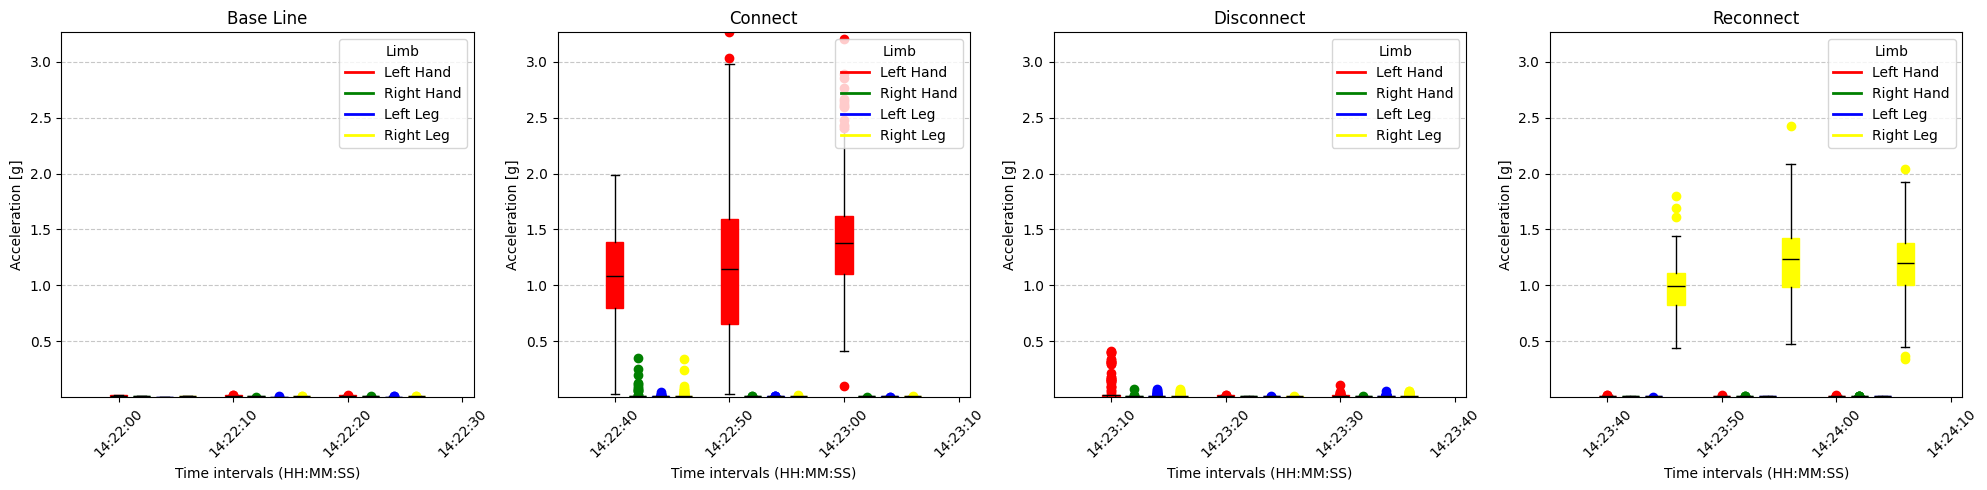

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



# Create a figure with one row and four columns
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Determine the global y-axis range
all_values = np.concatenate([data[column].values for data in segmented_data.values() for column in data.columns])
y_min, y_max = all_values.min(), all_values.max()

# Iterate over each event in segmented_data
for ax, (event_name, data) in zip(axes, segmented_data.items()):
    # Resample the data into 10-second intervals and prepare data for each limb
    limb_data = {column: [] for column in data.columns}
    time_intervals = [f"{idx.strftime('%H:%M:%S')}" for idx in data.resample('10s').mean().index]

    for column in data.columns:
        for start, end in zip(data.resample('10s').mean().index[:-1], data.resample('10s').mean().index[1:]):
            limb_data[column].append(data[column][start:end].values)

    # Plot the boxplot with specified colors for each limb
    for idx, (column, color) in enumerate(colors.items()):
        ax.boxplot(
            limb_data[column],
            positions=np.arange(len(limb_data[column])) + idx * 0.2,  # Offset for each limb
            widths=0.15,
            patch_artist=True,
            boxprops=dict(facecolor=color, color=color),
            medianprops=dict(color="black"),
            flierprops=dict(markerfacecolor=color, markeredgecolor=color),
        )

    # Customize the plot
    ax.set_title(f"{event_name}")
    ax.set_xlabel("Time intervals (HH:MM:SS)")
    ax.set_ylabel("Acceleration [g]")
    ax.set_xticks(ticks=np.arange(len(time_intervals)))
    ax.set_xticklabels(time_intervals, rotation=45)
    ax.set_ylim(y_min, y_max)  # Set the same y-axis range for all subplots
    ax.legend(handles=[plt.Line2D([0], [0], color=color, lw=2, label=column) for column, color in colors.items()],
              title="Limb", loc="upper right")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()
